In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

## 1. Load datasets with proper encoding fallback

In [5]:
try:
    df_train = pd.read_csv('Data_Train.csv', encoding='utf-8')
except UnicodeDecodeError:
    df_train = pd.read_csv('Data_Train.csv', encoding='latin-1')

try:
    df_test = pd.read_csv('Data_Test.csv', encoding='utf-8')
except UnicodeDecodeError:
    df_test = pd.read_csv('Data_Test.csv', encoding='latin-1')

## 2. Basic EDA and Visualization

### 2.1 Label Distribution

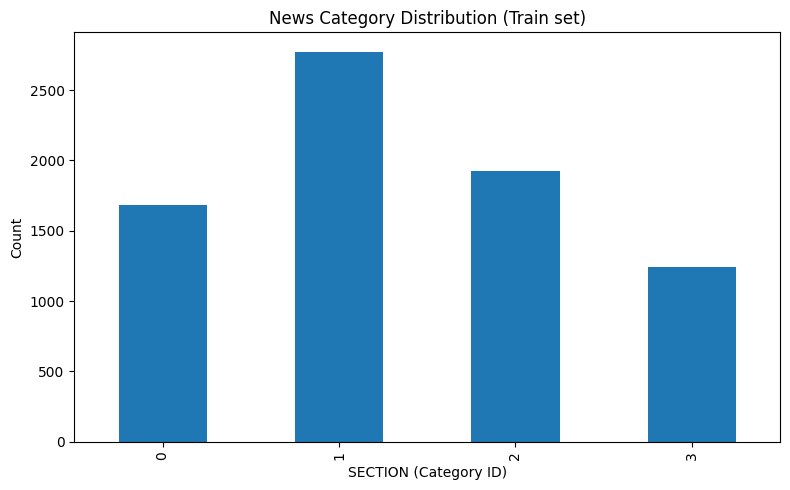

In [9]:
label_counts = df_train['SECTION'].value_counts().sort_index()
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar')
plt.title('News Category Distribution (Train set)')
plt.xlabel('SECTION (Category ID)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('label_distribution.png')
plt.show()

## 3. Text Preprocessing and Model Pipeline

In [10]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        strip_accents='unicode',
        lowercase=True,
        stop_words='english',
        ngram_range=(1,2),
        max_df=0.85,
        min_df=5
    )),
    ('clf', LogisticRegression(multi_class='auto', solver='saga', max_iter=1000, random_state=42))
])

## 4. Train/Validation Split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train['STORY'], df_train['SECTION'],
    test_size=0.1, random_state=42, stratify=df_train['SECTION']
)


## 5. Hyperparameter Tuning 

In [12]:
param_grid = {
    'tfidf__max_df': [0.75, 0.85],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1.0, 10]
}
grid = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
model = grid.best_estimator_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best parameters: {'clf__C': 10, 'tfidf__max_df': 0.75, 'tfidf__ngram_range': (1, 2)}


## 6. Validation Performance

In [13]:
y_pred_val = model.predict(X_val)
print("Validation Classification Report:\n", classification_report(y_val, y_pred_val))

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       169
           1       0.98      0.99      0.98       277
           2       0.98      0.97      0.98       192
           3       0.99      0.97      0.98       125

    accuracy                           0.98       763
   macro avg       0.98      0.98      0.98       763
weighted avg       0.98      0.98      0.98       763



### Confusion Matrix

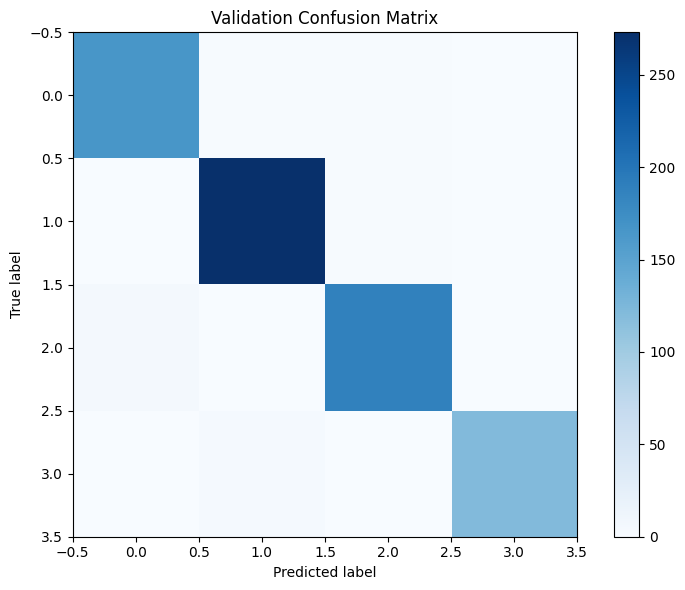

In [16]:
cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Validation Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

## 7. Retrain on Full Training Set and Predict on Test Set

In [17]:
model.fit(df_train['STORY'], df_train['SECTION'])

preds_test = model.predict(df_test['STORY'])

## 8. Save Predictions

In [21]:
df_output = pd.DataFrame({
    'SECTION': preds_test
})
df_output.to_csv('predictions.csv', index=False)
print("Saved predictions to 'predictions.csv'")
print(df_output)

Saved predictions to 'predictions.csv'
      SECTION
0           1
1           2
2           1
3           0
4           1
...       ...
2743        1
2744        1
2745        1
2746        0
2747        1

[2748 rows x 1 columns]


## 9. Feature Importance (top terms per class)

In [20]:
def show_top_features(vectorizer, classifier, categories, top_n=10):
    feature_names = vectorizer.get_feature_names_out()
    for i, cat in enumerate(categories):
        coefs = classifier.coef_[i]
        top_idx = coefs.argsort()[-top_n:][::-1]
        print(f"Top terms for category {cat}: ", [feature_names[j] for j in top_idx])

tfidf = model.named_steps['tfidf']
clf  = model.named_steps['clf']
show_top_features(tfidf, clf, model.classes_)

Top terms for category 0:  ['bjp', 'congress', 'party', 'political', 'election', 'modi', 'state', 'elections', 'ec', 'voters']
Top terms for category 1:  ['apple', 'users', 'google', 'app', 'smartphone', 'facebook', 'samsung', 'xiaomi', 'company', 'iphone']
Top terms for category 2:  ['film', 'actor', 'films', 'movie', 'life', 'kapoor', 'character', 'season', 'love', 'shared']
Top terms for category 3:  ['investors', 'trading', 'index', 'oil', 'gold', 'shares', 'market', 'markets', 'crore', 'stock']
